We can use the tsvs of still ambiguous forms to get stats on what POS are hard to macronize.

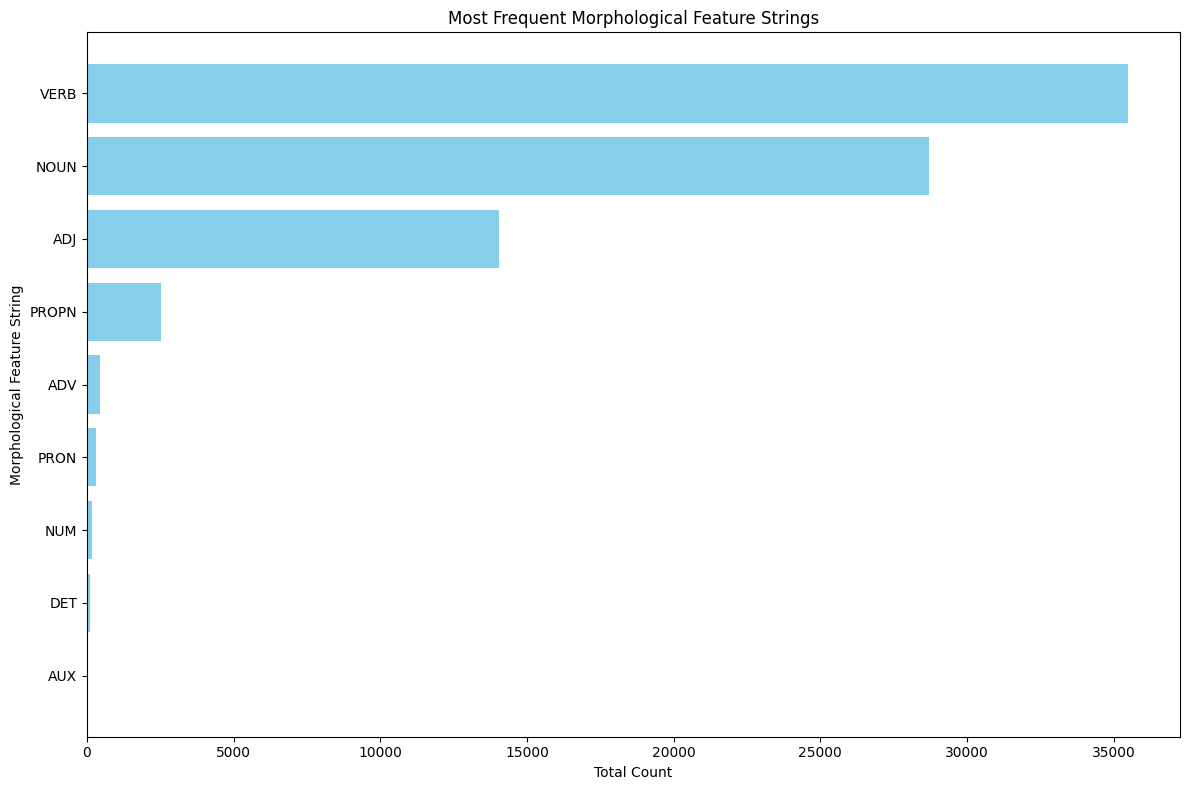

In [ ]:
from collections import defaultdict
import matplotlib.pyplot as plt
from pathlib import Path

def aggregate_feature_counts():
    pos_counts = defaultdict(int)
    tsv_dir = Path("/Users/albin/git/macronize-tlg/diagnostics/still_ambiguous")


    for tsv_file in tsv_dir.glob("*.tsv"):
        with tsv_file.open(encoding="utf-8") as f:
            for line in f:
                parts = line.strip().split("\t")
                if len(parts) != 5:
                    continue  # skip malformed lines
                try:
                    count = int(parts[0])
                    pos = parts[3]  # third column (0-based index)
                    pos_counts[pos] += count
                except ValueError:
                    continue  # skip header or bad lines

    return dict(pos_counts)

# --- Aggregate and Plot ---

counts = aggregate_feature_counts()

sorted_items = sorted(counts.items(), key=lambda x: x[1], reverse=True)

# Limit to top N entries for readability
top_n = 20
labels, values = zip(*sorted_items[:top_n])

# Plot bar chart
plt.figure(figsize=(12, 8))
plt.barh(labels, values, color='skyblue')
plt.xlabel("Total Count")
plt.ylabel("Morphological Feature String")
plt.title("Most Frequent Morphological Feature Strings")
plt.gca().invert_yaxis()  # Highest at the top
plt.tight_layout()
plt.show()

We need a baseline of the POS distribution in a normal text.

In [1]:
from collections import Counter
import glob
import xml.etree.ElementTree as ET
import spacy
from tqdm import tqdm
import matplotlib.pyplot as plt

# --- Step 1: Extract Text from TEI ---

def extract_text_from_tei(xml_path):
    ns = {'tei': 'http://www.tei-c.org/ns/1.0'}
    tree = ET.parse(xml_path)
    root = tree.getroot()

    body = root.find('.//tei:text/tei:body', ns)
    if body is None:
        return ""

    paragraphs = []
    for p in body.findall('.//tei:p', ns):
        if p.find('tei:label[@type="head"]', ns) is not None:
            continue  # skip headers
        text = ''.join(p.itertext()).strip()
        if text:
            paragraphs.append(text)

    for l in body.findall('.//tei:l', ns):
        text = ''.join(l.itertext()).strip()
        if text:
            paragraphs.append(text)

    return ' '.join(paragraphs)


# --- Step 2: Load and Concatenate Input ---

folder_path = "/Users/albin/Downloads/xmls_for_stats"
xml_files = sorted(glob.glob(f"{folder_path}/*.xml"))
length = len(xml_files)

texts = []
for xml_path in tqdm(xml_files, desc="Processing XML files", unit="file", total=length):
    text = extract_text_from_tei(xml_path)
    if text:
        texts.append(text)

input_text = ' '.join(texts)
print(f"Total characters in input: {len(input_text):,}")

# --- Step 3: Batch Input into 10 Chunks ---

def split_text(text, num_chunks):
    avg_len = len(text) // num_chunks
    chunks = []
    start = 0
    for i in range(num_chunks - 1):
        end = start + avg_len
        # Avoid breaking in the middle of a word:
        while end < len(text) and text[end].isalpha():
            end += 1
        chunks.append(text[start:end])
        start = end
    chunks.append(text[start:])  # last chunk
    return chunks


chunks = split_text(input_text, 10)
print(f"Split into {len(chunks)} chunks")


# --- Step 4: Run SpaCy on Each Chunk and Accumulate Counts ---

nlp = spacy.load("grc_odycy_joint_trf")

def count_pos_tags(texts) -> dict:
    total_counts = Counter()
    for doc in tqdm(nlp.pipe(texts, batch_size=16), total=len(texts), desc="Running POS tagging"):
        for token in doc:
            if not token.is_punct and not token.is_space:
                total_counts[token.pos_] += 1
    return dict(total_counts)

pos_counts = count_pos_tags(chunks)


# --- Step 5: Plot the Result ---

sorted_items = sorted(pos_counts.items(), key=lambda x: x[1], reverse=True)
top_n = 20
labels, values = zip(*sorted_items[:top_n])

plt.figure(figsize=(12, 8))
plt.barh(labels, values, color='skyblue')
plt.xlabel("Total Count")
plt.ylabel("Universal POS Tag")
plt.title("Baseline POS distribution")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("baseline_pos_dist.png")
plt.show()

Processing XML files: 100%|██████████| 150/150 [00:00<00:00, 376.73file/s]


Total characters in input: 8,518,829
Split into 10 chunks


Running POS tagging:   0%|          | 0/10 [00:00<?, ?it/s]/Users/albin/.pyenv/versions/odycy/lib/python3.12/site-packages/thinc/shims/pytorch.py:114: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self._mixed_precision):
Running POS tagging:   0%|          | 0/10 [10:26<?, ?it/s]


KeyboardInterrupt: 